In [1]:
import ginsim
import biolqm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

This notebook has been executed using the docker image `colomoto/colomoto-docker:2023-06-01`

# MACROPHAGE POLARIZATION LOGICAL MODELLING

This notebook represents a workflow of analyzing a Boolean Macrophage Polarization (MacPol) model that was extended from the efforts of Viviam Solangeli Bermúdez Paiva and Marco Fariñas. This type of network comprise of interactions with two possible discrete values: either 0 (OFF) or 1 (ON). The dynamic manner of the model can change based on the logical rules applied to the model components, which are further based on the interactions that connects the entities that comprise the network. The logical rules are defined using the Boolean operators AND ( & ), NOT ( ! ) and OR ( | ). They can be used alone or in combination, depending on the interaction(s) related to the particular component. In system biology, the model entities are referred to as nodes, while interactions between them are called edges. From here on, this is the naming that will be used.


In the expanded model, given the name MacPol 2.0, growth factors have been included; both as inputs and as outputs, as well as other entities interacting with these. This was mainly performed to investigate the effects growth factors as stimulants might have on macrophage polarization, but is also a valuable extension in the general functions of macrophages. The original MacPol model consisted of 68 nodes and 132 edges. MacPol 2.0 was expanded to contain 94 nodes and 200 edges. 10 of the added nodes are growth factors, both as inputs and outputs. 25 nodes are associated with the M1 phenotype, 26 with the M2 phenotype, 10 with both phenotypes, and four with the lipid metabolism. The expansion effort led to a total of 26 novel nodes and 68 interactions between them, determined by the nodes' 

Macrophages are an essential part of the innate immune system, and has several functions. They are both professional antigen-presenting cells to T-cells, and are further involved in the immune response through phagocytosis and the production and secretion of cytokines. 
The model focuses specifically on stimulis that lead to various production of cytokines, which are signalling molecules that can act on cells in the outside environment, including the producing cell itself. Based on the stimuli a macrophage cell receives, it will undergo an activation to either a dominant pro-inflammatory (M1) environment, or a dominant anti-inflammatory (M2) phenotypes. This will ultimately result in a distinct profile of cytokines secreted. It is important to note that this spectrum is continous, but that in the model it has been simplified to these discrete phenotypes. 

MacPol 2.0 is a boolean model consisting of nodes and edges. Nodes represent proteins, transcription factors, genes, or ions. The relationships between them are represented as edges. Green arrows connecting the nodes represent an activating effect, while red blunted arrows represents inhibitory effects on the target node. The model has four main "layers", where 1) the top nodes represent various stimuli that macrophages are able to receive due to 2) receptors. This ligand-receptor binding causes a 3) downstream activation/inhibition of molecules, essentially resulting in the 4) transcription of genes that will be translated to convey appropriate signals. These bottom nodes, thus have only ingoing nodes and no outgoing effects in the model. 

The main aim of the notebook is to compute stable states of the model with different growth factor stimuli, and to evaluate the fit of the model to that of THP-1 cell behaviour based on literature. Stable states describe the model's behaviour through updating schemes that will lead to a final state, based on the stimuli input. Each output node (not stimuli or receptor) will get their respective value: either 0 or 1. The result of such a simulation can be either one state, several states (multistability) or a cycle of states. If one or more states are reached, they are referred to as stable. If a state comprises of a single node, it is referred to as a fixed-point attractor. On the contrary, a cycle of states is referred to as the limit cycle because there will be one defined set of states that the model will rotate on. 
To achieve the desired results, bioLQM was used.


## Loading and visualizing the network

In [2]:
MacPol = ginsim.load("MacPol_2.zginml")
# ginsim.show(gs_model) --> This command does not show all colors from the original GINsim Model, therefore an image is shown instead.

![MacPol_2.png](MacPol_2.png) 

**Figure 1: Extended Macrophage Polarization (MacPol 2.0) model.**
<br>Nodes represent proteins, transcription factors, genes, or ions. Relationships between nodes are represented as edges, where green arrows represent activation, and red blunted arrows represent inhibition of the target node. Orange nodes: external stimuli and receptors. Turqoise nodes: Novel nodes of the extended model, that was not present in the model created by Bermúdez. Red nodes: entities related to the M1 phenotype. Blue nodes: entities related to the M2 phenotype. Purple nodes: entities related to both phenotypes. Yellow nodes: entities related to the lipid metabolism mediated by cytosolic enzyme phospholipase A2 (cPLA2).
Furthermore, the middle nodes in general represent intracellular signaling molecules and transcription factors, while the bottom nodes are molecules secreted or expressed (cytokines, chemokines, and membrane markers).

Converting the model to biolqm and pint compliant models:

In [3]:
lqm_model = ginsim.to_biolqm(MacPol)
pint_model = biolqm.to_pint(lqm_model)

Obtaining a summary of the general model properties:

In [4]:
pint_model.summary()

{'nb_automata': 93,
 'nb_local_states': 186,
 'max_local_states': 2,
 'nb_transitions': 305,
 'nb_states': 9903520314283042199192993792}

nb_automata signifies the number of nodes,
nb_local_states is the sum of the number of local states in each automaton,
max_local_states gives the number of local states of the largest automaton,
nb_transitions is the number of defined local transitions,
and nb_states is the total number of global states (corresponds to 2<sup>95</sup> in this case).

## Node - Phenotype associations

In MacPol 2.0, 6 of the novel nodes are related to the M1 phenotype, 2 with both phenotypes, and 8 with M2. Additionally, 5 input nodes and 5 receptors have also been added. Represented below are the nodes novel for MacPol 2.0, displayed below with their associated phenotype. 

In [5]:
Stimuli = {"Node": ['HGF_e', 'IGF1_e', 'TNFa_e', 'TGFb_e', 'VEGF_e'],
          "Phenotype": ['Stimuli','Stimuli','Stimuli','Stimuli','Stimuli']}
Stimuli_df = pd.DataFrame(data=Stimuli)

Receptor = {"Node": ['cMET', 'IGF1R', 'TNFR','TGFR','VEGFR','EP2R'],
           "Phenotype": ['Receptor','Receptor','Receptor','Receptor','Receptor','Receptor']}
Receptor_df = pd.DataFrame(data=Receptor)

M1 = {"Node": ['TRAF2','TAK1K63','Pell1'], 
                 "Phenotype": ['M1','M1','M1']}
M1_df = pd.DataFrame(data=M1)

M1_M2 = {"Node": ['SNAIL','PI3K'],
         "Phenotype": ['M1 & M2','M1 & M2']}
M1_M2_df = pd.DataFrame(data=M1_M2)

M2 = {"Node": ['PDL1', 'HGF', 'IGF1', 'VEGF','SMADhtc','SMAD7','SMAD6','TAK1K158'],
     "Phenotype":['M2','M2','M2','M2','M2','M2','M2','M2']}
M2_df = pd.DataFrame(data=M2)

LM = {"Node": ['Ca2', 'cPLA2a', 'PGE2', 'COX2'],
     "Phenotype":['LM', 'LM', 'LM', 'LM']}
LM_df = pd.DataFrame(data=LM)

Node_phenotype = pd.concat([Stimuli_df, Receptor_df, M1_df, M1_M2_df, M2_df, LM_df])

df_phen = pd.DataFrame(data=Node_phenotype)
df_phen.style.hide(axis='index')

Node,Phenotype
HGF_e,Stimuli
IGF1_e,Stimuli
TNFa_e,Stimuli
TGFb_e,Stimuli
VEGF_e,Stimuli
cMET,Receptor
IGF1R,Receptor
TNFR,Receptor
TGFR,Receptor
VEGFR,Receptor


**Table 1. Novel MacPol 2.0 nodes and their associated phenotype.** LM = Lipid metabolism.

## Identification of stable states using bioLQM

The original MacPol model developed by Viviam Bérmudez Paiva, has here been extended to include intracellular and extracellular effects of growth factors. This is due to the wish of identifying the stable states for when growth factors are present in the extracellular environment, along with stimuli for polarizing the macrophages into a phenotype, identical to what was performed in the THP-1 experiments. As a treatment to polarize the cells into an M1-like phenotype, IFNg + LPS was used, while IL-13 + IL-4 was used as a M2 treatment. 

First, all possible stable states was computed using bioLQM, to investigate whether the amount of stable states is as expected, or if there a more. This will later be useful for the downstream analyses.

In [6]:
# Computing all stable states
fixpoints = biolqm.fixpoints(lqm_model)
fix_df = pd.DataFrame(fixpoints)
fix_df

,IFNg,IFNgR,P2R,GMCSF,CSF2RA,IL6_e,IL6R,IL1b_e,IL1R,LPS,TLR4,IC,FCGR,IL4,IL4RA,IL13,IL10_e,IL10R,PGE2_e,EP4R,STAT5,STAT1,IRF5,IRF3,IFNb,NFkB,RelA,IL1a,IFNa,iNOS,IL1b,TNFa,IL12,CCL4,CCL2,CD80,CCR7,TBK1,TRAF6,JNK,p38,MNK1,SOCS3,AP1,IL6,IL1Ra,ERK,PPARG,JMJD3,STAT6,SOCS1,KLF4,IRF4,cMaf,Arg1,CD200R,CCL18,CCL17,CCL22,CD206,IL10,STAT3,TGFb,CD163,cPLA2a,PGE2,COX2,Ca2,HGF_e,cMET,PI3K,TGFb_e,TGFR,SNAIL,VEGF_e,VEGFR,PDL1,VEGF,IGF1,IGF1_e,IGF1R,HGF,TNFa_e,TNFR,TRAF2,TAK1K63,SMADhtc,TAK1K158,SMAD7,SMAD6,MyD88,Pell1,EP2R
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33615,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,1,1,1,1,0,1,1,1
33616,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
33617,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
33618,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1


**Table 2. All possible stable states that can be reached by MacPol 2.0.**

When computing the stable states using bioLQM, as shown above in Table 1, a total of 32932 stable states is obtained. This is without defining any initial input states. As shown in the model, there are a total of 15 inputs (ligands), and thus it is expected to obtain a total of 2<sup>15</sup> = 32768 stable states. An excess amount of stable states as is the situation here, signifies the presence of multistability for some input conditions, i.e. the system is able to achieve multiple stable states under the same external conditions.

### COMPARISON OF METHODS FOR CREATING INITIAL CONDITIONS AND OBTAINING STABLE STATES

When comparing this notebook to that of Viviam, it was identified that we used different methods for defining stable states. This difference had to be investigated to check if the resulting dataframes are identical or not, and if not, the method used here had to be changed.


In [7]:
# Viviam's method:
condition = biolqm.perturbation(lqm_model, "IFNg%1 LPS%1 VEGF_e%0 GMCSF%0 IL6_e%0 IL1b_e%0 IC%0 PGE2_e%0 IL4%0 IL13%0 IL10_e%0 HGF_e%0 TGFb_e%0 IGF1_e%0")
fps_condition = biolqm.fixpoints(condition, "-u asynchronous")
condition_df = pd.DataFrame(fps_condition)
condition_df

,IFNg,IFNgR,P2R,GMCSF,CSF2RA,IL6_e,IL6R,IL1b_e,IL1R,LPS,TLR4,IC,FCGR,IL4,IL4RA,IL13,IL10_e,IL10R,PGE2_e,EP4R,STAT5,STAT1,IRF5,IRF3,IFNb,NFkB,RelA,IL1a,IFNa,iNOS,IL1b,TNFa,IL12,CCL4,CCL2,CD80,CCR7,TBK1,TRAF6,JNK,p38,MNK1,SOCS3,AP1,IL6,IL1Ra,ERK,PPARG,JMJD3,STAT6,SOCS1,KLF4,IRF4,cMaf,Arg1,CD200R,CCL18,CCL17,CCL22,CD206,IL10,STAT3,TGFb,CD163,cPLA2a,PGE2,COX2,Ca2,HGF_e,cMET,PI3K,TGFb_e,TGFR,SNAIL,VEGF_e,VEGFR,PDL1,VEGF,IGF1,IGF1_e,IGF1R,HGF,TNFa_e,TNFR,TRAF2,TAK1K63,SMADhtc,TAK1K158,SMAD7,SMAD6,MyD88,Pell1,EP2R
0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,1,0


In [8]:
# My chosen method:
inpM1 = ('IFNg == 1 & LPS == 1 & VEGF_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
filtered_fixpoints = fix_df.query(inpM1)
filtered_fixpoints


,IFNg,IFNgR,P2R,GMCSF,CSF2RA,IL6_e,IL6R,IL1b_e,IL1R,LPS,TLR4,IC,FCGR,IL4,IL4RA,IL13,IL10_e,IL10R,PGE2_e,EP4R,STAT5,STAT1,IRF5,IRF3,IFNb,NFkB,RelA,IL1a,IFNa,iNOS,IL1b,TNFa,IL12,CCL4,CCL2,CD80,CCR7,TBK1,TRAF6,JNK,p38,MNK1,SOCS3,AP1,IL6,IL1Ra,ERK,PPARG,JMJD3,STAT6,SOCS1,KLF4,IRF4,cMaf,Arg1,CD200R,CCL18,CCL17,CCL22,CD206,IL10,STAT3,TGFb,CD163,cPLA2a,PGE2,COX2,Ca2,HGF_e,cMET,PI3K,TGFb_e,TGFR,SNAIL,VEGF_e,VEGFR,PDL1,VEGF,IGF1,IGF1_e,IGF1R,HGF,TNFa_e,TNFR,TRAF2,TAK1K63,SMADhtc,TAK1K158,SMAD7,SMAD6,MyD88,Pell1,EP2R
18066,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0
18067,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,1,0


As can be seen, the two methods yield the same results, except that the row labels differ. The row label from my method is coming from the index in fix_df, whereas for Viviam's method, the number will be either 0 or 1 due to creating one data frame per condition. This does not matter result-wise and hence, the conclusion is that I can continue with my method of choice. 

### Creating initial conditions and computing the corresponding stable states

To compute the reachable stable states with different stimuli, initial state conditions must first be defined. M0 has been included, in addition to M1 and M2 because it establishes a baseline which can be used for comparison. Additionally, it offers a more nuanced and complete picture of how growth factors influence macrophage polarization across the spectrum of phenotypes. 

In [9]:
# Creating initial state conditions:
inpM0 = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM0_HGF = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 1 & TGFb_e == 0 & IGF1_e == 0')
inpM0_VEGF = ('IFNg == 0 & LPS == 0 & VEGF_e == 1 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM0_GMCSF = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 1 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM0_IGF1 = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 1')
inpM0_TNFa = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & TNFa_e == 1 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM0_TGFb = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 1 & IGF1_e == 0')
inpM0_IL6 = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 1 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM0_IL4 = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 1 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM0_IL13 = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 1 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')

inpM1 = ('IFNg == 1 & LPS == 1 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM1_HGF = ('IFNg == 1 & LPS == 1 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 1 & TGFb_e == 0 & IGF1_e == 0')
inpM1_VEGF = ('IFNg == 1 & LPS == 1 & VEGF_e == 1 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM1_GMCSF = ('IFNg == 1 & LPS == 1 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 1 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM1_IGF1 = ('IFNg == 1 & LPS == 1 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 1')
inpM1_TNFa = ('IFNg == 1 & LPS == 1 & VEGF_e == 0 & TNFa_e == 1 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 1 & IGF1_e == 0')
inpM1_TGFb = ('IFNg == 1 & LPS == 1 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM1_IL6 = ('IFNg == 1 & LPS == 1 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 1 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 1 & IGF1_e == 0')
inpM1_IL4 = ('IFNg == 1 & LPS == 1 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 1 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 1 & IGF1_e == 0')
inpM1_IL13 = ('IFNg == 1 & LPS == 1 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 1 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 1 & IGF1_e == 0')

inpM2 = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 1 & IL13 == 1 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM2_HGF = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 1 & IL13 == 1 & IL10_e == 0 & HGF_e == 1 & TGFb_e == 0 & IGF1_e == 0')
inpM2_VEGF = ('IFNg == 0 & LPS == 0 & VEGF_e == 1 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 1 & IL13 == 1 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM2_GMCSF = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 1 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 1 & IL13 == 1 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM2_IGF1 = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 1 & IL13 == 1 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 1')
inpM2_TNFa = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & TNFa_e == 1 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 1 & IL13 == 1 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM2_TGFb = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 1 & IL13 == 1 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 1 & IGF1_e == 0')
inpM2_IL6 = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 1 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 1 & IL13 == 1 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM2_IL4 = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 1 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 1 & IL13 == 1 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM2_IL13 = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 1 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 1 & IL13 == 1 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')


# Preparing indexes for all output nodes
markers = ['TRAF2','Pell1','TAK1K63','IRF3','TBK1','STAT1','STAT5','IRF5','IFNa','IFNb','TNFa','CCL2','IL12','RelA','IL1b','IL1a','CCL4','NFkB','CCR7','CD80','iNOS',
           'ERK','HGF','IL10','PDL1','PPARG','Arg1','CCL18','STAT6','JMJD3','STAT3','SOCS1','IRF4','CCL17','cMaf','CCL22','IGF1','CD200R','VEGF','KLF4','CD206','CD163','TGFb','SMAD7','SMAD6','SMADhtc','TAK1K158',
           'TRAF6','JNK','SOCS3','p38','MNK1','AP1','PI3K','SNAIL','IL6','IL1Ra',
           'Ca2','cPLA2a','PGE2','COX2']

phen_arrays = [['M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1', 
                'M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2',
                'M1 & M2','M1 & M2','M1 & M2','M1 & M2','M1 & M2','M1 & M2','M1 & M2','M1 & M2','M1 & M2','M1 & M2',
                'LM', 'LM', 'LM', 'LM'], markers]

# Preparing indexes for output nodes with only in-edges
out_markers = ['IFNa', 'IFNb', 'TNFa', 'CCL2', 'IL1b', 'IL1a', 'IL12', 'CCL4', 'CCR7', 'CD80', 'iNOS', 
               'COX2', 'IL6', 'IL1Ra', 'IL10', 'HGF', 'PDL1', 'CCL17', 'CCL18', 'CCL22', 
               'Arg1', 'IGF1', 'CD200R', 'CD206', 'CD163', 'TGFb', 'VEGF' ]

out_phen_array = [['M1', 'M1', 'M1', 'M1', 'M1', 'M1', 'M1', 'M1', 'M1', 'M1', 'M1', 
                   'LM','M1 & M2', 'M1 & M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M2'], out_markers]


# DEFINING HEATMAP COLORS
cmap_dict = {0: '#DFCAB0', 1: '#F5EBDD', 2: '#F3A1A1', 3: '#BBEC8D'}
cmap = ListedColormap([cmap_dict[i] for i in range(4)])


# Creating lists of nodes based on phenotype
M1_nodes = df_phen[df_phen['Phenotype'] == 'M1']['Node'].tolist()
M2_nodes = df_phen[df_phen['Phenotype'] == 'M2']['Node'].tolist()

# Concatenating the lists
M1_M2_nodes = M1_nodes + M2_nodes

In [10]:
# FORMATTING FUNCTIONS

# Coloring nodes where cells without stimuli matches the equivalent node with stimuli in another row. 
# .iloc is integer based location of cell values in dataframe.
def format_diff_expression(df, markers_override = markers, start_row = 1):
    for row_count in range(start_row, len(df)):                           
        for marker in range(len(markers_override)):
            if df.iloc[0][marker] != df.iloc[row_count][marker]:
                if df.iloc[0][marker] > df.iloc[row_count][marker]:
                    df.iloc[row_count][marker] = 2
                elif df.iloc[0][marker] < df.iloc[row_count][marker]:
                    df.iloc[row_count][marker] = 3
    return df


# Presenting activated M1/M2 nodes as ratios:

def ratio(df, stimuli_list):
    # Counting the activated M1 and M2 nodes
    M1_active = df.loc[:, pd.IndexSlice['M1', :]].apply(lambda x: sum(x.isin([1, 3])), axis=1)
    M2_active = df.loc[:, pd.IndexSlice['M2', :]].apply(lambda x: sum(x.isin([1, 3])), axis=1)

    # Creating a column that contains the ratio as a fraction (as a string)
    ratios = M1_active.astype(str) + '/' + M2_active.astype(str)

    # Create the DataFrame
    df = pd.DataFrame({'Stimuli': stimulis, 'Ratio': ratios})

    return df


Workflow for the following two cells:
1) Setting the initial states. ".query" in the pandas library asks a boolean expression to each of the columns in the Dataframe.

2) Selecting only the output nodes to appear in heat map.

3) Creating a multilevel index with the phenotypes, which makes it possible to store and manipulate data with an arbitrary number of dimensions in lower dimensional data structures like dataframes.

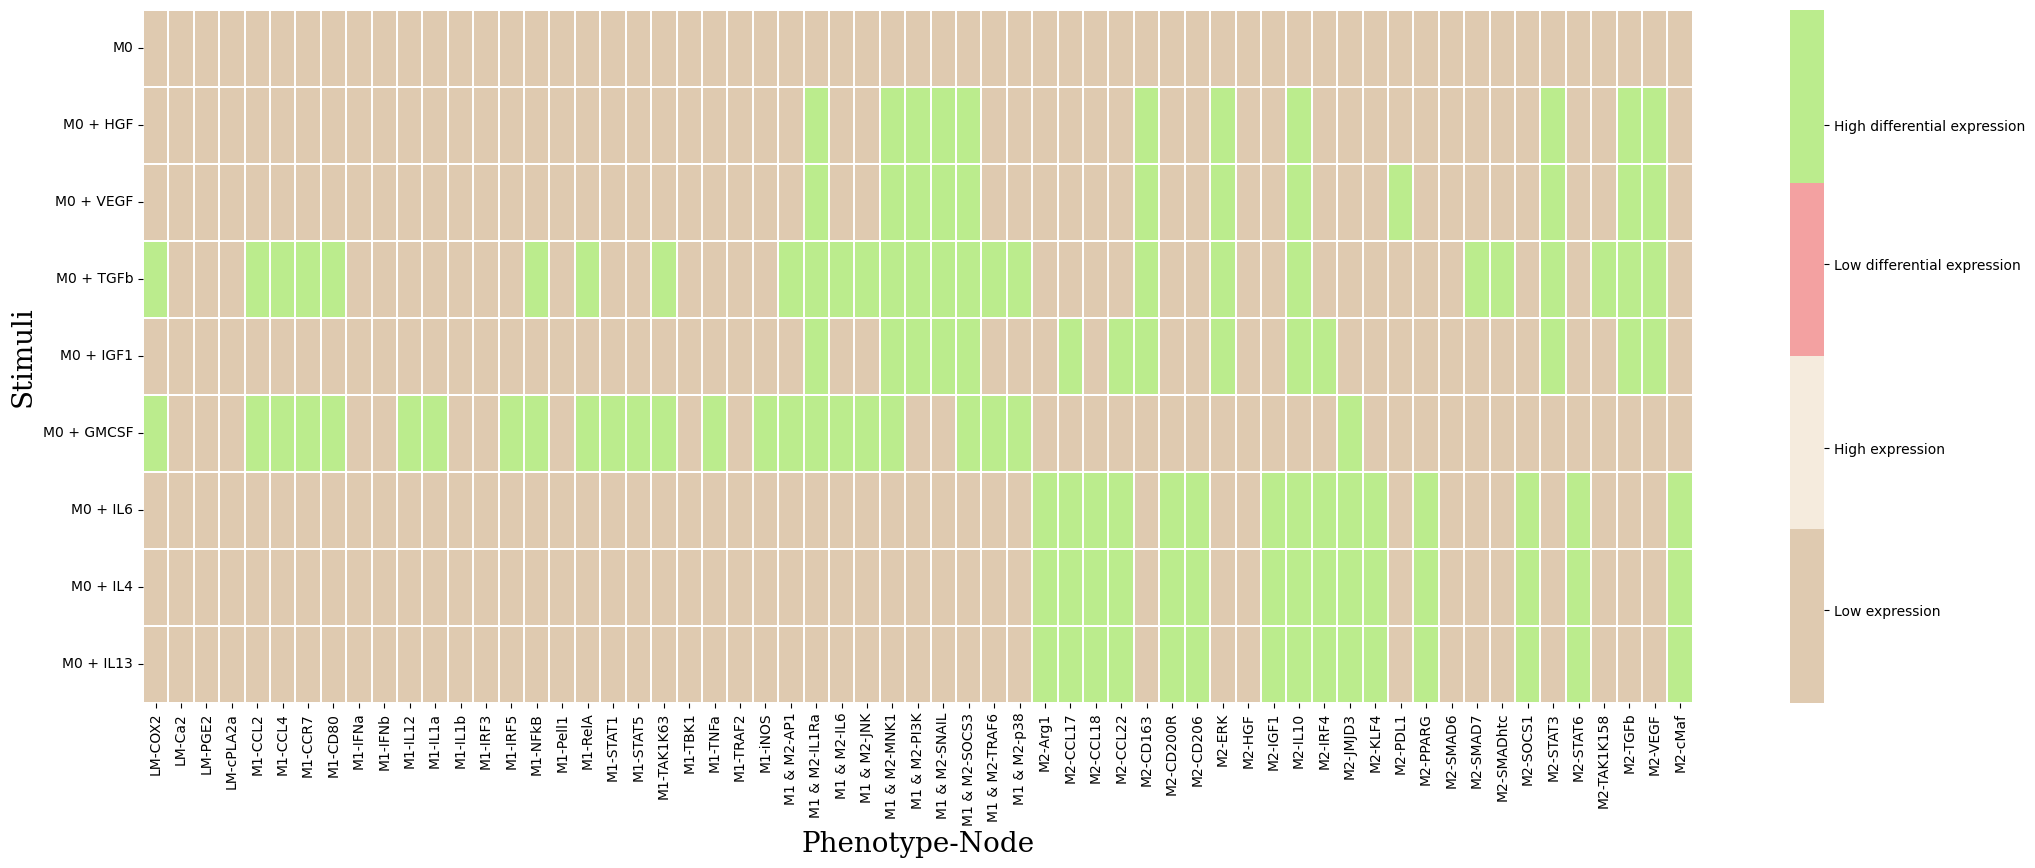

In [11]:
# Setting initial states with growth factors HGF, VEGF, PlGF, TGFb, IGF1 in M0 macrophages
# Selecting only the output nodes.
# Creating a multilevel index with the phenotypes.

M0_ON = fix_df.query(inpM0)
M0_ON = M0_ON[markers]
M0_ON.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M0_HGF = fix_df.query(inpM0_HGF)
M0_HGF = M0_HGF[markers]
M0_HGF.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M0_VEGF = fix_df.query(inpM0_VEGF)
M0_VEGF = M0_VEGF[markers]
M0_VEGF.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M0_TGFb = fix_df.query(inpM0_TGFb)
M0_TGFb = M0_TGFb[markers]
M0_TGFb.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M0_IGF1 = fix_df.query(inpM0_IGF1)
M0_IGF1 = M0_IGF1[markers]
M0_IGF1.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M0_GMCSF = fix_df.query(inpM0_GMCSF)
M0_GMCSF = M0_GMCSF[markers]
M0_GMCSF.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M0_IL6 = fix_df.query(inpM0_IL6)
M0_IL6 = M0_IL6[markers]
M0_IL6.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M0_IL4 = fix_df.query(inpM0_IL4)
M0_IL4 = M0_IL4[markers]
M0_IL4.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M0_IL13 = fix_df.query(inpM0_IL13)
M0_IL13 = M0_IL13[markers]
M0_IL13.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])


frames = [M0_ON, M0_HGF, M0_VEGF, M0_TGFb, M0_IGF1, M0_GMCSF, M0_IL6, M0_IL4, M0_IL13]

# Concatenating all the filtered dataframes into one large dataframe
results = pd.concat(frames, keys=["M0", "M0 + HGF", "M0 + VEGF", "M0 + TGFb", "M0 + IGF1", "M0 + GMCSF", "M0 + IL6", "M0 + IL4", "M0 + IL13"])

# Resetting the index to move the stimuli names to columns
results.reset_index(inplace=True)

# Lexsorting the MultiIndex
results = results.sort_index(axis=1)

fig, ax = plt.subplots(figsize=(25, 9)) 

# Filter the DataFrame to keep only the columns representing the data for the heatmap
M0data = results.drop(['level_0', 'level_1'], axis=1)

# Giving nodes with differential expression from M0 values =2 if overexpressed and =3 if underexpressed.
M0data = format_diff_expression(M0data)


M0map = sns.heatmap(M0data, cmap = cmap, square = False, 
                    linewidth=0.1, cbar_kws={"shrink": 1}) 
 
# Manually specifying discrete legend labelling 
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.4, 1.1, 1.9, 2.5])
colorbar.set_ticklabels(['Low expression', 'High expression', 'Low differential expression', 
                         'High differential expression'])


# Setting y-axis labels using the 'level_0' column which contains the stimuli names
M0map.set_yticklabels(results['level_0'].values, rotation=0)

M0map.set_ylabel("Stimuli", fontsize=20, font="Serif" )
M0map.set_xlabel("Phenotype-Node", fontsize=20, font="Serif")


plt.show()


**Figure 2. Predicted stable states in M0 macrophages using growth factors as stimuli.**
<br>M0 macrophages along with the stimuli of different growth factors. 
Green cells are differentially activated nodes, red cells are differentially inactivated nodes. Nodes with a light beige color are nodes with high expression, but not different to the M0 phenotype without any other activations. Dark beige cells are the same, but low expression. 


In [12]:
# CALCULATING THE RATIO OF ACTIVATED M1 VS M2 NODES

# Creating a list of stimulis
stimulis = ['M0', 'M0 + HGF', 'M0 + VEGF', 'M0 + TGFb', 'M0 + VEGF', 'M0 + GMCSF', 'M0 + IL6', 'M0 + IL4', 'M0 + IL13']

ratio(M0data, stimulis)


,Stimuli,Ratio
0,M0,0/0
1,M0 + HGF,0/6
2,M0 + VEGF,0/7
3,M0 + TGFb,7/9
4,M0 + VEGF,0/9
5,M0 + GMCSF,14/1
6,M0 + IL6,0/15
7,M0 + IL4,0/15
8,M0 + IL13,0/15


**Table 3. Activated M1/M2 ratio for each stimuli in M0 macrophages.** From row 1-8, the ratios represent differentially expressed genes.

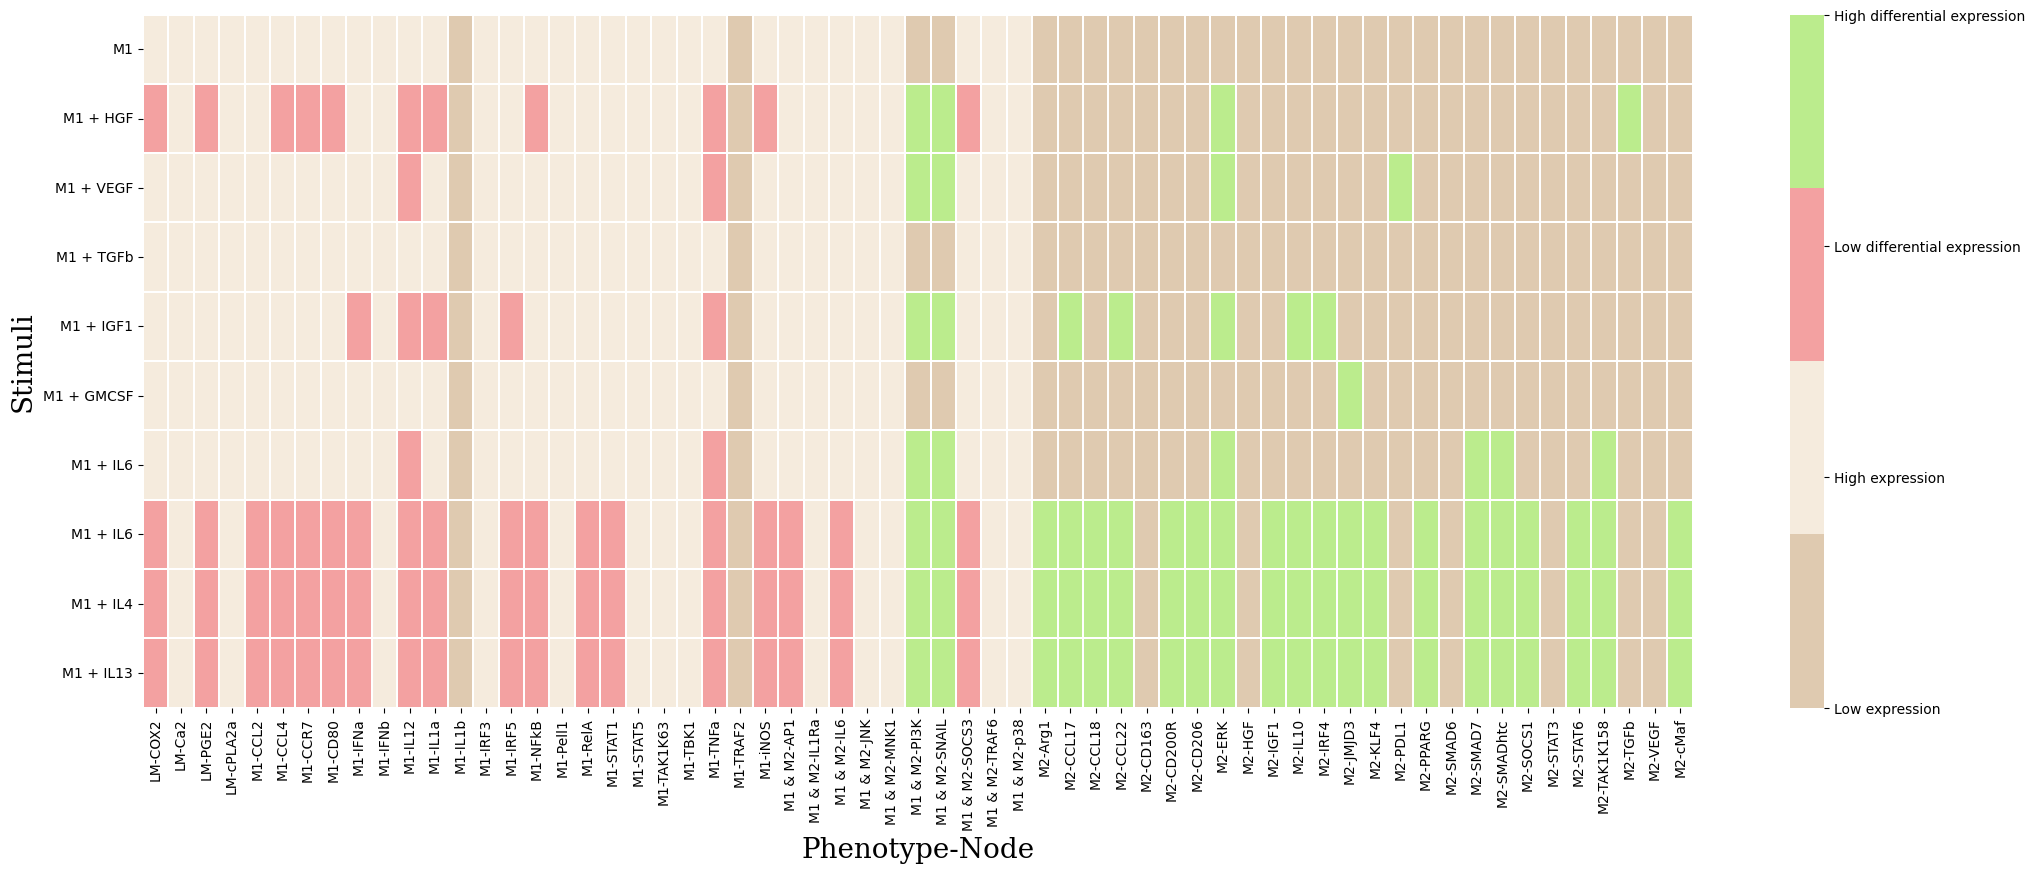

In [13]:
# Setting initial states with growth factors HGF, VEGF, PlGF, TGFb, IGF1 along with M1 phenotype stimuli.
# Selecting only the output nodes.
# Creating a multilevel index with the phenotypes.

M1_ON = fix_df.query(inpM1)
M1_ON = M1_ON[markers]
M1_ON.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M1_HGF = fix_df.query(inpM1_HGF)
M1_HGF = M1_HGF[markers]
M1_HGF.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M1_VEGF = fix_df.query(inpM1_VEGF)
M1_VEGF = M1_VEGF[markers]
M1_VEGF.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M1_TGFb = fix_df.query(inpM1_TGFb)
M1_TGFb = M1_TGFb[markers]
M1_TGFb.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M1_IGF1 = fix_df.query(inpM1_IGF1)
M1_IGF1 = M1_IGF1[markers]
M1_IGF1.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M1_GMCSF = fix_df.query(inpM1_GMCSF)
M1_GMCSF = M1_GMCSF[markers]
M1_GMCSF.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M1_IL6 = fix_df.query(inpM1_IL6)
M1_IL6 = M1_IL6[markers]
M1_IL6.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M1_IL4 = fix_df.query(inpM1_IL4)
M1_IL4 = M1_IL4[markers]
M1_IL4.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M1_IL13 = fix_df.query(inpM1_IL13)
M1_IL13 = M1_IL13[markers]
M1_IL13.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])


frames = [M1_ON, M1_HGF, M1_VEGF, M1_TGFb, M1_IGF1, M1_GMCSF, M1_IL6, M1_IL4, M1_IL13]

# Concatenating all the filtered dataframes into one large dataframe
results = pd.concat(frames, keys=["M1", "M1 + HGF", "M1 + VEGF", "M1 + TGFb", "M1 + IGF1", "M1 + GMCSF", "M1 + IL6", "M1 + IL4", "M1 + IL13"])

# Resetting the index to move the stimuli names to columns
results.reset_index(inplace=True)

# Lexsorting the MultiIndex
results = results.sort_index(axis=1)

fig, ax = plt.subplots(figsize=(25, 9)) 

# Filter the DataFrame to keep only the columns representing the data for the heatmap
M1data = results.drop(['level_0', 'level_1'], axis=1)

# Coloring nodes where M1 matches the equivalent node in another row. 
M1data = format_diff_expression(M1data)

M1map = sns.heatmap(M1data, cmap = cmap, square = False, 
                    linewidth=0.1, cbar_kws={"shrink": 1}) 
 
# Manually specifying discrete legend labelling 
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 1, 2, 3])
colorbar.set_ticklabels(['Low expression', 'High expression', 'Low differential expression', 
                         'High differential expression'])


# Setting y-axis labels using the 'level_0' column which contains the stimuli names
M1map.set_yticklabels(results['level_0'].values, rotation=0)

M1map.set_ylabel("Stimuli", fontsize=20, font="Serif" )
M1map.set_xlabel("Phenotype-Node", fontsize=20, font="Serif")

plt.show()


**Figure 3. Predicted stable states in M1 macrophages.**
<br>M1 input ligands IFNg and LPS are on, along with one other growth factor stimuli. Green cells are differentially activated nodes, red cells are differentially inactivated nodes. Nodes with a light beige color are nodes with high expression, but not different to the M0 phenotype without any other activations. Dark beige cells are the same, but low expression.

As shown in Figure 3, there is one predicted stable state for each condition.

In [14]:
# CALCULATING THE RATIO OF ACTIVATED M1 VS M2 NODES

# Creating a list of stimulis
stimulis = ['M1', 'M1 + HGF', 'M1 + VEGF', 'M1 + TGFb', 'M1 + IGF1', 'M1 + GMCSF', 'M1 + IL6 (1)', 'M1 + IL6 (2)', 'M1 + IL4', 'M1 + IL13']

ratio(M1data, stimulis)

,Stimuli,Ratio
0,M1,19/0
1,M1 + HGF,11/2
2,M1 + VEGF,17/2
3,M1 + TGFb,19/0
4,M1 + IGF1,14/5
5,M1 + GMCSF,19/1
6,M1 + IL6 (1),17/4
7,M1 + IL6 (2),6/19
8,M1 + IL4,6/19
9,M1 + IL13,6/19


**Table 4. M1/M2 ratio for activated nodes for each stimuli in M1 macrophages.**

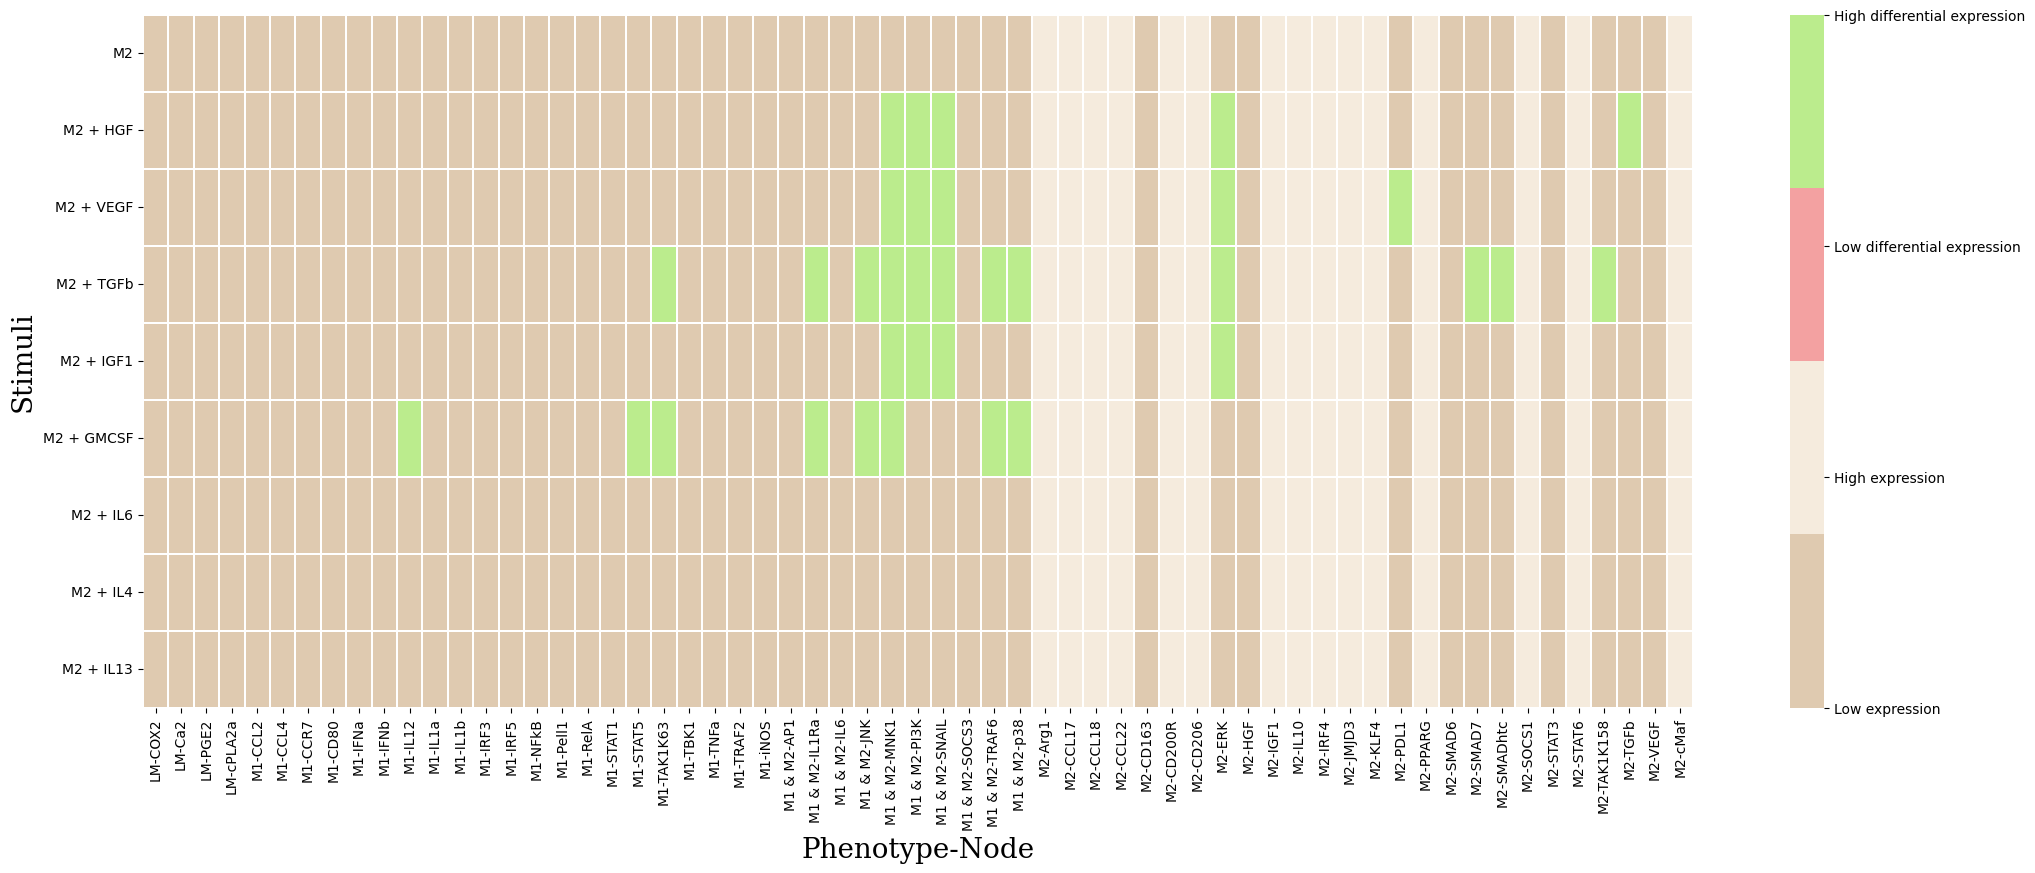

In [15]:
# Setting initial states with growth factors HGF, VEGF, PlGF, TGFb, IGF1 along with M2 phenotype stimuli. 
# Here, IL4 and IL13 will have the same outcome, as they are already part of the polarization treatment for M2 phenotype.
# They have however still been added for simplifying the comparison across the three dataframes further down.
# Selecting only the output nodes.
# Creating a multilevel index with the phenotypes.

M2_ON = fix_df.query(inpM2) # Here, this will also represent results with IL-4 and IL-3 as growth factor treatments
M2_ON = M2_ON[markers]
M2_ON.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M2_HGF = fix_df.query(inpM2_HGF)
M2_HGF = M2_HGF[markers]
M2_HGF.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M2_VEGF = fix_df.query(inpM2_VEGF)
M2_VEGF = M2_VEGF[markers]
M2_VEGF.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M2_TGFb = fix_df.query(inpM2_TGFb)
M2_TGFb = M2_TGFb[markers]
M2_TGFb.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M2_IGF1 = fix_df.query(inpM2_IGF1)
M2_IGF1 = M2_IGF1[markers]
M2_IGF1.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M2_GMCSF = fix_df.query(inpM2_GMCSF)
M2_GMCSF = M2_GMCSF[markers]
M2_GMCSF.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M2_IL6 = fix_df.query(inpM2_IL6)
M2_IL6 = M2_IL6[markers]
M2_IL6.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M2_IL4 = fix_df.query(inpM2_IL4)
M2_IL4 = M2_IL4[markers]
M2_IL4.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M2_IL13 = fix_df.query(inpM2_IL13)
M2_IL13 = M2_IL13[markers]
M2_IL13.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

frames = [M2_ON, M2_HGF, M2_VEGF, M2_TGFb, M2_IGF1, M2_GMCSF, M2_IL6, M2_IL4, M2_IL13]

# Concatenating all the filtered dataframes into one large dataframe
results = pd.concat(frames, keys=["M2", "M2 + HGF", "M2 + VEGF", "M2 + TGFb", "M2 + IGF1", "M2 + GMCSF", "M2 + IL6", "M2 + IL4", "M2 + IL13"]).copy()

# Resetting the index to move the stimuli names to columns
results.reset_index(inplace=True)

# Lexsorting the MultiIndex
results = results.sort_index(axis=1)

fig, ax = plt.subplots(figsize=(25, 9))                   
                    
# Filter the DataFrame to keep only the columns representing the data for the heatmap
M2data = results.drop(['level_0', 'level_1'], axis=1)  

# Coloring nodes where M2 matches the equivalent node in another row. 
M2data = format_diff_expression(M2data)


M2map = sns.heatmap(M2data, cmap = cmap, square = False, 
                    linewidth=0.1, cbar_kws={"shrink": 1}) 
 
# Manually specifying discrete legend labelling 
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 1, 2, 3])
colorbar.set_ticklabels(['Low expression', 'High expression', 'Low differential expression', 
                         'High differential expression'])


# Setting y-axis labels using the 'level_0' column which contains the stimuli names
M2map.set_yticklabels(results['level_0'].values, rotation=0)

M2map.set_ylabel("Stimuli", fontsize=20, font="Serif")
M2map.set_xlabel("Phenotype-Node", fontsize=20, font="Serif")
plt.show()


**Figure 4. Predicted stable states in M2 macrophages**
<br>M2 input ligands IL-4 + IL-13 are on, along with the stimuli of different growth factor. Green cells are differentially activated nodes, red cells are differentially inactivated nodes. Nodes with a light beige color are nodes with high expression, but not different to the M0 phenotype without any other activations. Dark beige cells are the same, but low expression.

As shown in Figure 4, there is one predicted stable state for each initial condition.

In [16]:
# CALCULATING THE RATIO OF ACTIVATED M1 VS M2 NODES

# Creating a list of stimulis
stimulis = ['M2', 'M2 + HGF', 'M2 + VEGF', 'M2 + TGFb', 'M2 + IGF1', 'M2 + GMCSF', 'M2 + IL6', 'M2 + IL4', 'M2 + IL13']

print("""Table 5. Activated M1/M2 ratio for each stimuli in M2 macrophages.""")
ratio(M2data, stimulis) 

Table 5. Activated M1/M2 ratio for each stimuli in M2 macrophages.


,Stimuli,Ratio
0,M2,0/15
1,M2 + HGF,0/17
2,M2 + VEGF,0/17
3,M2 + TGFb,1/19
4,M2 + IGF1,0/16
5,M2 + GMCSF,3/15
6,M2 + IL6,0/15
7,M2 + IL4,0/15
8,M2 + IL13,0/15


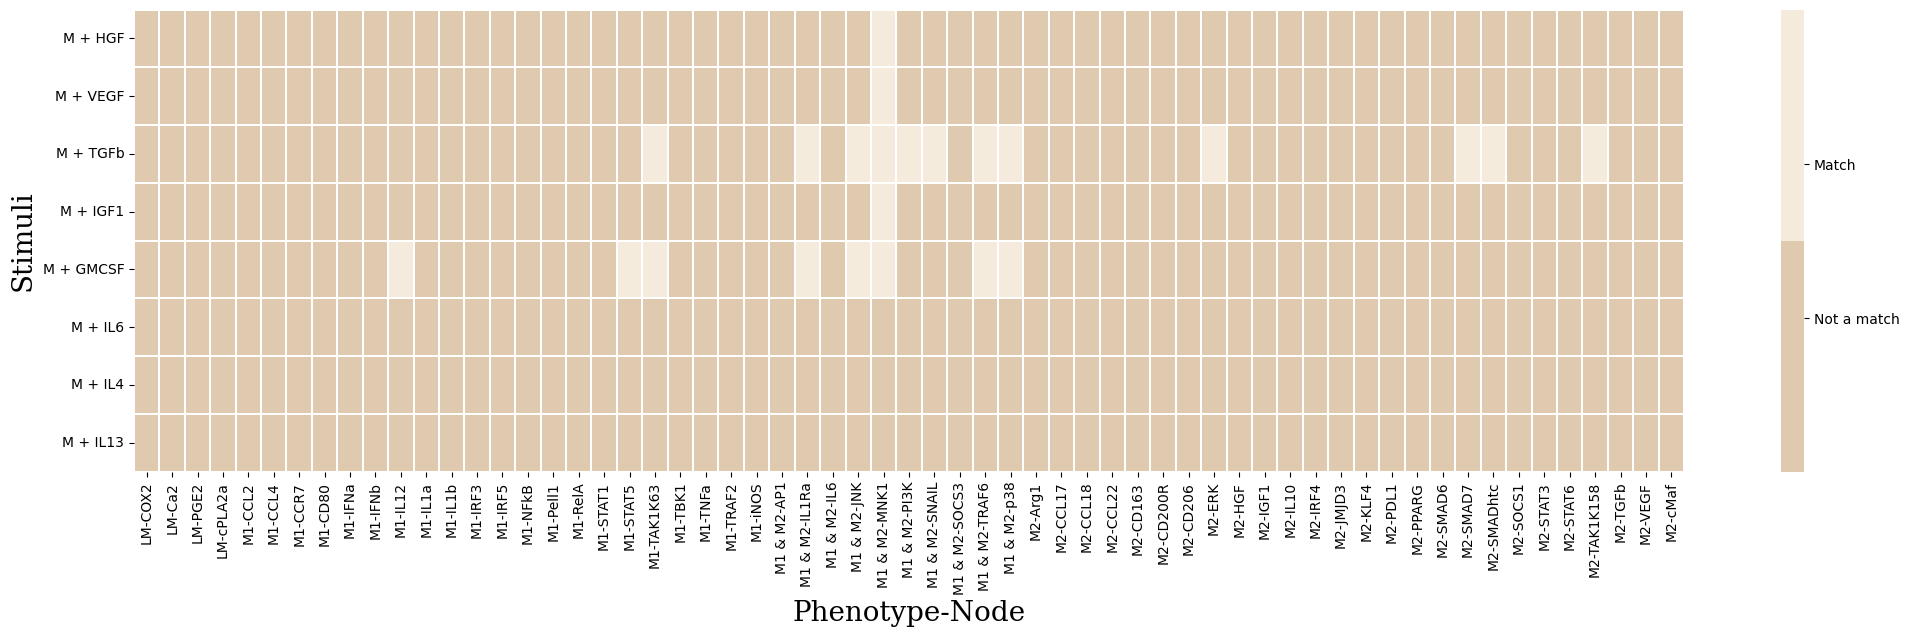

In [17]:
# COMPARING EXPRESSION ACROSS THE THREE DATAFRAMES (M0, M1 AND M2)

# Creating a copy of the M2 dataframe
compare_df = M2data.copy(deep=True)

fig, ax = plt.subplots(figsize=(25, 6))                   

# Comparing dataframes for M0, M1 and M2 to identify which markers with differential expression are common
for row_count in range(1,len(M2data)):
    for marker in range(len(markers)):
        if M0data.iloc[row_count][marker] == 2 or M0data.iloc[row_count][marker] == 3:
            if M1data.iloc[row_count][marker] == 2 or M1data.iloc[row_count][marker] == 3:
                if M2data.iloc[row_count][marker] == 2 or M1data.iloc[row_count][marker] == 3:
                    compare_df.iloc[row_count][marker] = 1 # match
                else:
                    compare_df.iloc[row_count][marker] = 0 # Not a match
            
compare_df = compare_df.drop(index=0)

cmap_dict = {0: '#DFCAB0', 1: '#F5EBDD'}
cmap_compare = ListedColormap([cmap_dict[i] for i in range(2)])


compare_map = sns.heatmap(compare_df, cmap = cmap_compare, square = False, 
                    linewidth=0.1, cbar_kws={"shrink": 1}) 
 
# Manually specifying discrete legend labelling 
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([1, 2])
colorbar.set_ticklabels(['Not a match', 'Match'])

compare_map.set_yticklabels(["M + HGF", "M + VEGF", "M + TGFb", "M + IGF1", "M + GMCSF", "M + IL6", "M + IL4", "M + IL13"], rotation=0)
compare_map.set_ylabel("Stimuli", fontsize=20, font="Serif")
compare_map.set_xlabel("Phenotype-Node", fontsize=20, font="Serif")
plt.show()

**Figure 5. Common differential expression**
<br> Expression = 1 signifies a common differential expression across all expression dataframes (M0, M1 and M2) in the same exact cell (Match). Expression = 0 means no match across all dataframes (Not a match).

## Comparing THP-1 expression data from experiments with model simulations

The THP-1 (Tohoko Hospital Pediatrics-1) cell line are cells consisting of large, round sin-
gle cells derived from the blood of a patient with acute monocytic leukemia in 1980. These cells serve as a very representative system to use when studying macrophage behaviour and polarization. Therefore, it is important to check whether the model is able to represent the behaviour of the cell line and make accurate predictions. 
For that reason, a stable state analysis using the same inputs as identified in literature where THP-1 cells are used, was set to run a simulation. The resulting heatmap of the computed stable states are shown below.

In [18]:
# Creating initial state conditions

inp_IFNg_LPS = ('IFNg == 1 & LPS == 1 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inp_IFNg = ('IFNg == 1 & LPS == 0 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inp_LPS = ('IFNg == 0 & LPS == 1 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inp_IL4 = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 1 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inp_IL10 = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 1 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inp_IL4_IL13 = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & TNFa_e == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 1 & IL13 == 1 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')

# Preparing indexes for desired
THP1_markers = ['STAT1', 'CCL2', 'CCR7', 'IL1b', 'IRF5', 'RelA', 'TNFa','iNOS', 'IL6', 'SOCS3', 'TGFb', 'CCL18', 'CCL22', 'IRF4', 'JMJD3', 'CD206', 'PPARG', 'SOCS1', 'IL10', 'CCL17', 'Arg1', 'COX2']

THP1_phen_arrays = [['M1','M1','M1','M1','M1','M1','M1','M1','M1 & M2','M1 & M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','LM'], THP1_markers]

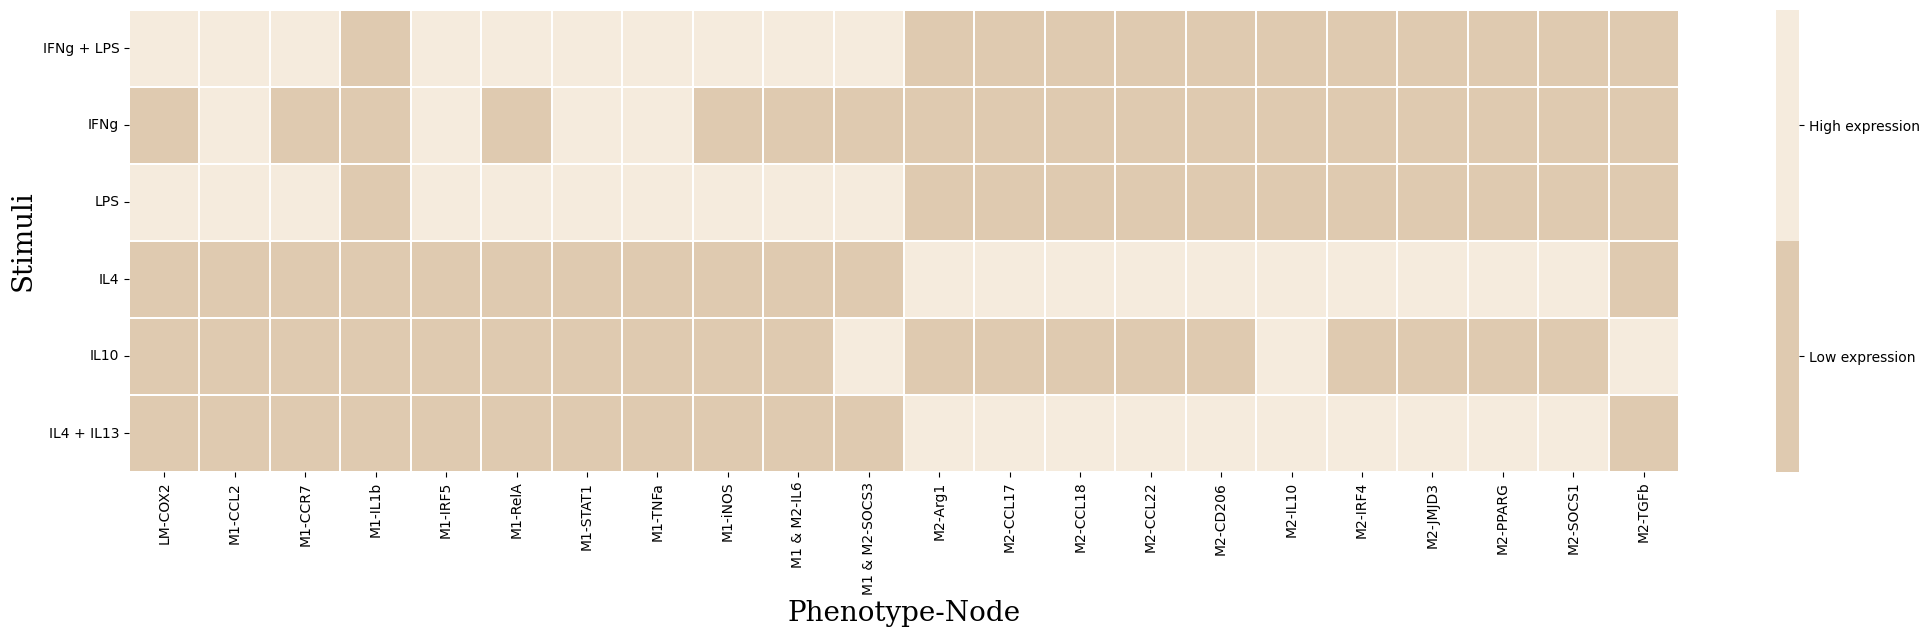

In [19]:
# Setting initial states with various stimulis (inputs).
# Selecting only the output nodes.
# Creating a multilevel indexs with the phenotypes.

IFNg_LPS = fix_df.query(inp_IFNg_LPS)
IFNg_LPS = IFNg_LPS[THP1_markers]
IFNg_LPS.columns = pd.MultiIndex.from_arrays(THP1_phen_arrays, names= ['Phenotype', 'Node'])

IFNg = fix_df.query(inp_IFNg)
IFNg = IFNg[THP1_markers]
IFNg.columns = pd.MultiIndex.from_arrays(THP1_phen_arrays, names= ['Phenotype', 'Node'])

LPS = fix_df.query(inp_LPS)
LPS = LPS[THP1_markers]
LPS.columns = pd.MultiIndex.from_arrays(THP1_phen_arrays, names= ['Phenotype', 'Node'])

IL4 = fix_df.query(inp_IL4)
IL4 = IL4[THP1_markers]
IL4.columns = pd.MultiIndex.from_arrays(THP1_phen_arrays, names= ['Phenotype', 'Node'])

IL10 = fix_df.query(inp_IL10)
IL10 = IL10[THP1_markers]
IL10.columns = pd.MultiIndex.from_arrays(THP1_phen_arrays, names= ['Phenotype', 'Node'])

IL4_IL13 = fix_df.query(inp_IL4_IL13)
IL4_IL13 = IL4_IL13[THP1_markers]
IL4_IL13.columns = pd.MultiIndex.from_arrays(THP1_phen_arrays, names= ['Phenotype', 'Node'])

frames_THP1 = [IFNg_LPS, IFNg, LPS, IL4, IL10, IL4_IL13]

# Concatenating all the filtered dataframes into one large dataframe
THP1results = pd.concat(frames_THP1, keys=["IFNg + LPS", "IFNg", "LPS", "IL4", "IL10", "IL4 + IL13"]).copy()
# print(results['level_0'].values)

# Resetting the index to move the stimuli names to columns
THP1results.reset_index(inplace=True)

# Lexsorting the MultiIndex
THP1results = THP1results.sort_index(axis=1)

fig, ax = plt.subplots(figsize=(25, 6)) 

# Filter the DataFrame to keep only the columns representing the data for the heatmap
THP1_data = THP1results.drop(['level_0','level_1'], axis=1)

# Defining discrete color values
cmap_dict = {0: '#DFCAB0', 1: '#F5EBDD'}
cmap_thp1 = ListedColormap([cmap_dict[i] for i in range(2)])

THP1_map = sns.heatmap(THP1_data, cmap = cmap_thp1, square = False, 
                    linewidth=0.1, cbar_kws={"shrink": 1}) 
 
# Manually specifying discrete legend labelling 
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25,0.75])
colorbar.set_ticklabels(['Low expression', 'High expression'])


# Setting y-axis labels using the 'level_0' column which contains the stimuli names
THP1_map.set_yticklabels(THP1results['level_0'].values, rotation=0)

THP1_map.set_ylabel("Stimuli", fontsize=20, font="Serif" )
THP1_map.set_xlabel("Phenotype-Node", fontsize=20, font="Serif")

plt.show()


**Figure 6. MacPol 2.0 computed stable states using stimuli from literature.**
<br>Stimuli and markers used in literature regarding experiments with THP-1 cells, are used as calculate stable states using MacPol 2.0.